# DSCI100: Group31 Project Report
### Members
- Divya Gupta
- Arshdeep Jassi
- Cassiel Jung
- Lily Zhang

## 1.0 Introduction
When watching tennis games, players who have high rank seem to have a similar physique. Our team got curious if there is a certain favorable body type for a tennis player. Thus, throughout this project, we are going to answer the question **“What is the relationship between the physique of tennis players and their probability of winning?”**. To answer the question, the dataset *‘Game results for Top 500 Players from 2017-2019’* will be used which contains the data of each tennis game played by Top 500 Players. Each row corresponds to each game and it includes information of players such as their height, age, and hand. Since the dataset contains 3 years of data, we will calculate the probability of winning of each player for each year based on their age. In terms of regression model, we are going to test with both knn regression model and linear regression model to compare their accuracy and use the most suitable model for our question.

## 2.0 Method & Results
Libraries to use:
1. tidyverse: to use read_csv/ggplot and many other basic data analysis functions
2. repre: to represent string/binary variables
3. tidymodels: to use regression model later

In [41]:
library(tidyverse)
library(repr)
library(tidymodels)

### 2.1 Read data from the web
Loading dataset from the google drive using read_csv() function and url.

In [42]:
tennis_raw_data <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
head(tennis_raw_data)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


### 2.2 Clean and Wrangling the dataset

The original data downloded from google drive contains information of winner and loser in each game. Our original tought was using number of games win per player but while cleaning the data we realized that number of games played per player varies a lot. Since we cannot say player who played 2 games and won both and player who played 100 games and won 2 as the same, we decided to calculate probability of winning.  
  
We followed below steps to clean and calculate probability of winning:
1. Round up winner_age to whole number with function round() to calculate probability of winning in **each year**
3. **Get winner's height, hand and number of winning** in each year using group_by() and summarise() functions.
4. **remove duplicate** using unique() function.
5. Repleat step 1 to 4 for loser_data
6. **Bind winner_data and loser_data** then calculate probability of winning to have format *[player_id, age, height, hand, num_winning, num_losing, num_games, prob_winning]*
7. Filter players who played less than 8 games
8. Convert left-handed player's hand data to 0 and right-handed player's hand data to 1  
  
*Step 7 and 8 are to increase accuracy of model*


In [43]:
# get number of game won for each player per year
winner_data <- tennis_raw_data %>%
                mutate(age = round(winner_age, digit = 0)) %>%
                group_by(winner_id, age) %>%
                summarise(height = winner_ht, hand = winner_hand, num_winning = n()) %>%
                rename(player_id = winner_id) %>%
                unique()

# get number of game lost for each player per year
loser_data <- tennis_raw_data %>%
                mutate(age = round(loser_age, digit = 0)) %>%
                group_by(loser_id, age) %>%
                summarise(height = loser_ht, hand = loser_hand, num_losing = n()) %>%
                rename(player_id = loser_id) %>%
                unique()

# bind winner_data and loser_data then calculate probability of winning
tennis_clean <- bind_rows(winner_data, loser_data) %>%
                as_tibble() %>%
                replace_na(list(num_winning = 0, num_losing = 0)) %>%
                group_by(player_id, age) %>%
                summarize(height = height, 
                          hand = hand, 
                          num_winning = sum(num_winning), 
                          num_losing = sum(num_losing),
                          num_games = num_winning + num_losing,
                          prob_winning = (num_winning / num_games)*100) %>%
                unique() %>%
                filter(num_games >= 8) %>%
                mutate(hand = case_when(hand == "L" ~ 0, hand == "R" ~ 1))

tennis_clean <- tennis_clean[complete.cases(tennis_clean),]

head(tennis_clean)

`summarise()` regrouping output by 'winner_id', 'age' (override with `.groups` argument)

`summarise()` regrouping output by 'loser_id', 'age' (override with `.groups` argument)

`summarise()` regrouping output by 'player_id', 'age' (override with `.groups` argument)



player_id,age,height,hand,num_winning,num_losing,num_games,prob_winning
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100644,20,198,1,45,16,61,73.77049
100644,21,198,1,48,19,67,71.64179
100644,22,198,1,42,22,64,65.62500
103333,38,208,1,11,13,24,45.83333
103333,39,208,1,10,19,29,34.48276
103333,40,208,1,10,13,23,43.47826


### 2.3 Splitting dataset
Split dataset into two: 75% of train set and 25% of test set

In [44]:
set.seed(42) 
tennis_split <- initial_split(tennis_clean, prop = 0.75)  
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

### 2.4 Summarize data
#### 2.4.1 Summarize quantitative variables
One of the metrics that can be explored is the average values of the quantitative variables we are considering in the analysis such as height and age. The table below shows the average height (in cm) and age (years) of both the winners and the losers. As seen below, the average height and age of both winners and losers is similar.

In [45]:
tennis_avg_summarization <- tennis_raw_data %>% 
                            select(winner_ht, winner_age, loser_ht, loser_age) %>% 
                            summarize(avg_win_height = mean(winner_ht, na.rm = TRUE),
                                      avg_win_age = mean(winner_age, na.rm = TRUE), 
                                      avg_loser_height = mean(loser_ht, na.rm = TRUE), 
                                      avg_loser_age = mean(loser_age, na.rm = TRUE))

tennis_avg_summarization

avg_win_height,avg_win_age,avg_loser_height,avg_loser_age
<dbl>,<dbl>,<dbl>,<dbl>
186.5343,27.68495,186.1811,27.49811


#### 2.4.2 Summarize categorical variable
There is one more variable we are considering for the analysis which is handedness of the players. Since it is a categorical variable, to explore the number of games won with each dominant hand, we can just count up the number of winners for each dominant hand. This can be seen in the following table.

In [46]:
tennis_num_winners_hand <- tennis_raw_data %>% 
                            select(winner_hand) %>% 
                            group_by(winner_hand) %>% 
                            summarize(number_winners = n())

tennis_num_winners_hand

`summarise()` ungrouping output (override with `.groups` argument)



winner_hand,number_winners
<chr>,<int>
L,979
R,5831
U,56


### 2.5 Visualize summarized data
#### 2.5.1 Winning games vs Winner's handedness
By using the tennis_num_winners_hand assigned previously, a visual representation can be created that compares the number of games won with the different handedness of players using bar plots. Colour-blind friendly colours were also added to help better visualize the plot. This was done using the ggplot and geom_bar functions.

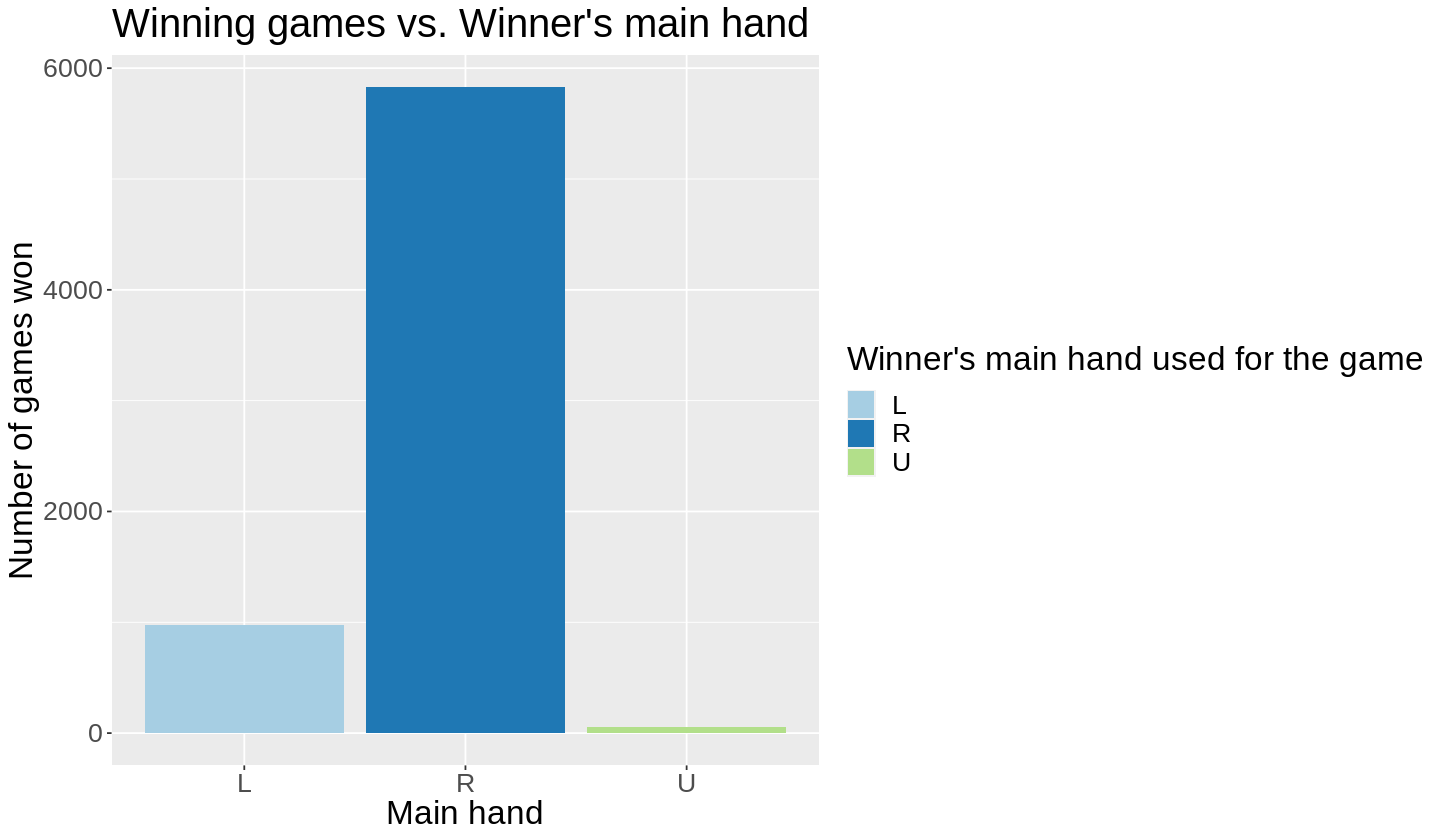

In [47]:
options(repr.plot.height = 7, repr.plot.width = 12)
library(RColorBrewer)

winning_hand_visual <- ggplot(tennis_num_winners_hand, aes(x = winner_hand, y = number_winners, fill = winner_hand)) +
                            geom_bar(stat = "identity") +
                            labs(x = "Main hand", y = "Number of games won", fill = "Winner's main hand used for the game") +
                            ggtitle("Winning games vs. Winner's main hand") +
                            theme(text = element_text(size = 20)) +
                            scale_fill_brewer(palette = 'Paired')

winning_hand_visual



#### 2.5.2 Probability of winning vs Winner's height
By using the training data set, a scatter graph can be produced that visualizes the distribution of probability of winnig for player’s heights. This was done using the ggplot and geom_point functions.

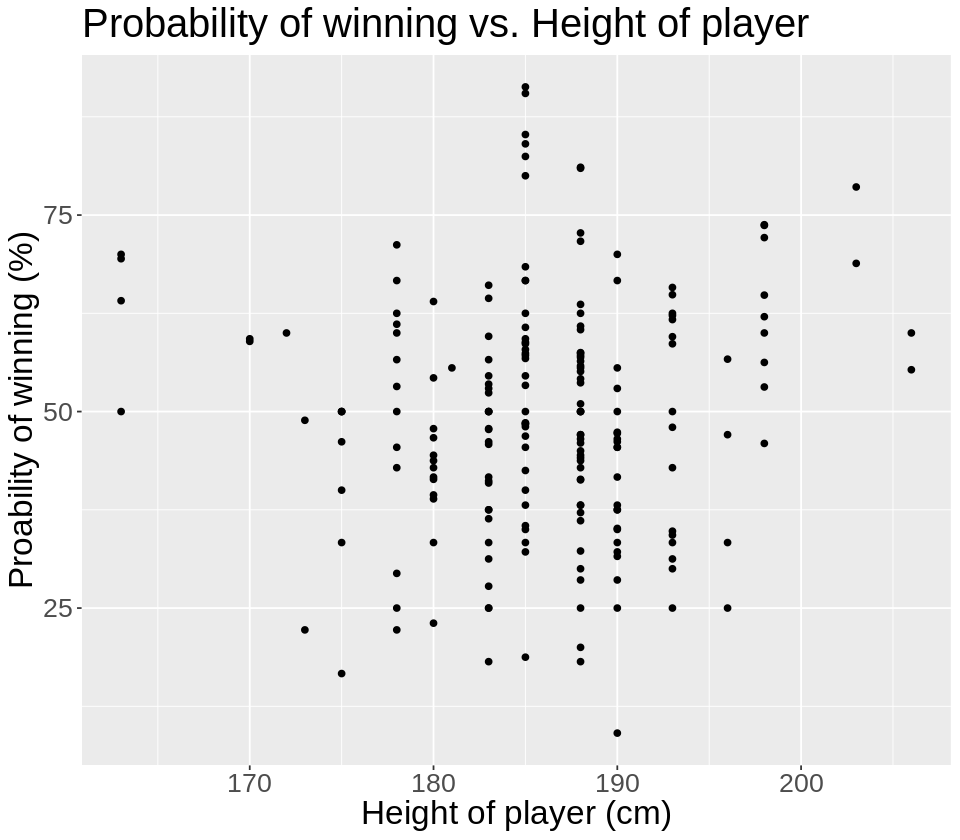

In [48]:
options(repr.plot.height = 7, repr.plot.width = 8)
height <- tennis_train %>%
            ggplot(aes(x = height, y = prob_winning)) +
                geom_point() +
                labs(x = "Height of player (cm)", y = "Proability of winning (%)") +
                ggtitle("Probability of winning vs. Height of player") +
                theme(text = element_text(size = 20))
height

#### 2.4.3 Probability of winning vs player's age
Similar to the previous graph and using the same data, a scatter graph is also used to visualize the distribution of the probability of winning for the player’s age. This was done using the ggplot and geom_point functions.

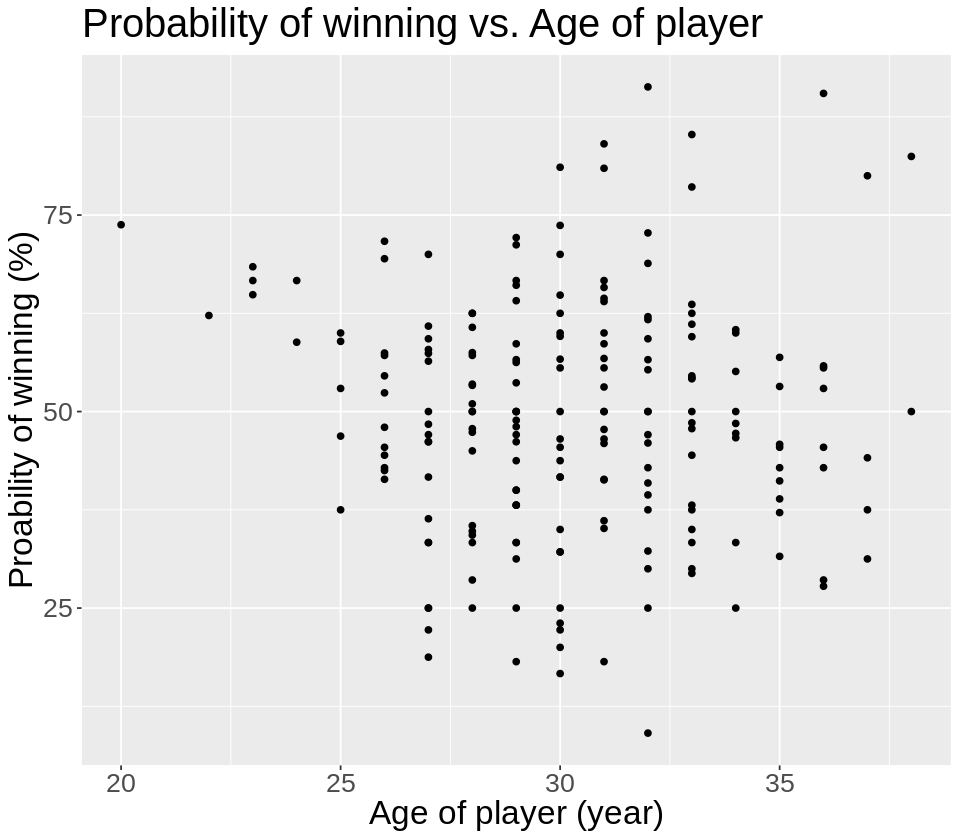

In [49]:
options(repr.plot.height = 7, repr.plot.width = 8)
age <- tennis_train %>%
        ggplot(aes(x = age, y = prob_winning)) +
            geom_point() +
            labs(x = "Age of player (year)", y = "Proability of winning (%)") +
            ggtitle("Probability of winning vs. Age of player") +
            theme(text = element_text(size = 20))
age

### 2.5 Data Analysis
As mentioned briefly in the introduction, we were not sure which regression model should we use to answer our question. Therefore, we decided to try both K-nearest neighbour and linear regression and pick the one with highest accuracy.

#### 2.5.1 knn Regression

In [50]:
set.seed(1234)

tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
                  set_engine("kknn") %>%
                  set_mode("regression") 

tennis_recipe <- recipe(prob_winning ~ height + age + hand, data = tennis_train) %>%
                  step_scale(all_predictors()) %>%
                  step_center(all_predictors())

tennis_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [51]:
set.seed(1234)
tennis_vfold <- vfold_cv(tennis_train, v = 5, strata = prob_winning)
tennis_workflow <- workflow() %>%
                    add_recipe(tennis_recipe) %>%
                    add_model(tennis_spec)
tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [52]:
set.seed(2019)
gridvals <- tibble(neighbors = seq(from = 1, to = 100))

tennis_results <- tennis_workflow %>%
                    tune_grid(resamples = tennis_vfold, grid = gridvals) %>%
                    collect_metrics() %>%
                    filter(.metric == "rmse")
            
head(tennis_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,19.87991,5,0.9364086,Model001
2,rmse,standard,15.87371,5,0.4636290,Model002
3,rmse,standard,15.43543,5,0.4559845,Model003
4,rmse,standard,15.33270,5,0.5021499,Model004
5,rmse,standard,15.30499,5,0.6860417,Model005
6,rmse,standard,15.31277,5,0.8881364,Model006


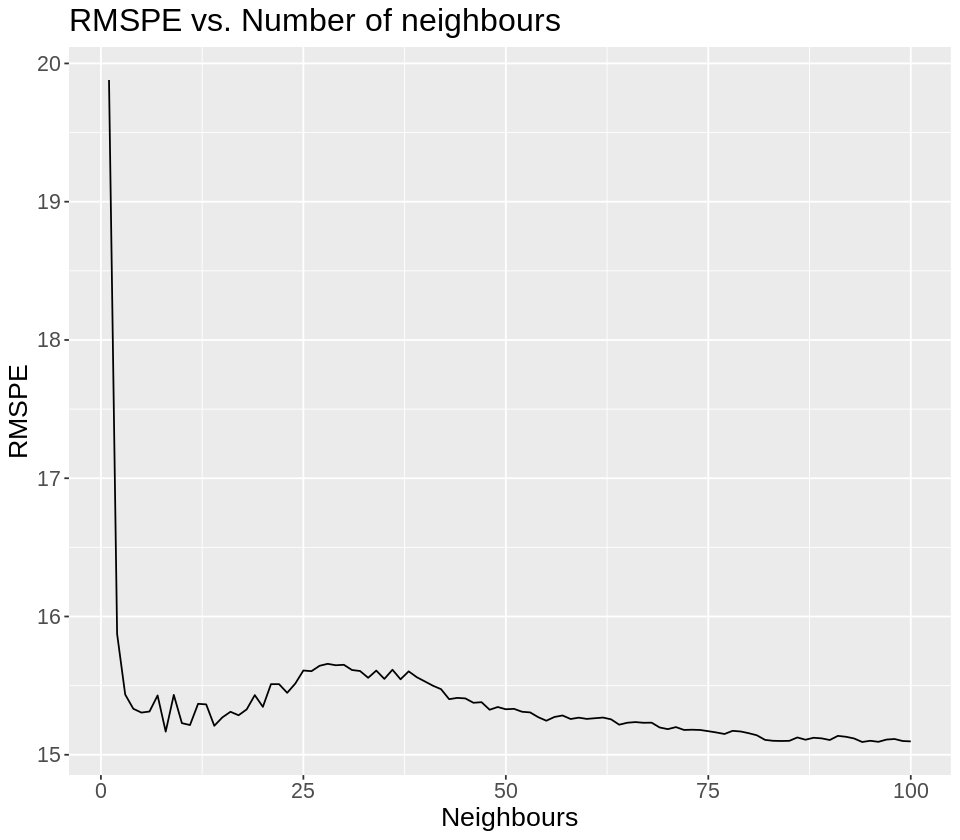

In [53]:
# visualize the change in neighbours
tennis_results_plot <- ggplot(tennis_results, aes(x = neighbors, y = mean)) +
                        geom_line() +
                        xlab("Neighbours") +
                        ylab("RMSPE") + 
                        ggtitle("RMSPE vs. Number of neighbours ") + 
                        theme(text = element_text(size = 16))
                        
tennis_results_plot

In [54]:
set.seed(2020)

tennis_min <- tennis_results %>%
               filter(.metric == "rmse") %>%
               arrange(mean) %>% 
               slice(1)

tennis_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
94,rmse,standard,15.09237,5,0.6639385,Model094


Although the RMSPE is the lowest when there are 94 neighbours, it is actually underfitting, so in this case we chose k = 13 where the RMSPE is also low but it's not undersitting or overfitting.

In [82]:
set.seed(1234)

tennis_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>%
         set_engine("kknn") %>%
         set_mode("regression")

tennis_best_fit <- workflow() %>%
         add_recipe(tennis_recipe) %>%
         add_model(tennis_best_spec) %>%
         fit(data = tennis_train)

tennis_summary <- tennis_best_fit %>%
          predict(tennis_test) %>%
          bind_cols(tennis_test) %>%
          metrics(truth = prob_winning, estimate = .pred)

tennis_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,14.4299068
rsq,standard,0.1200362
mae,standard,10.8814578


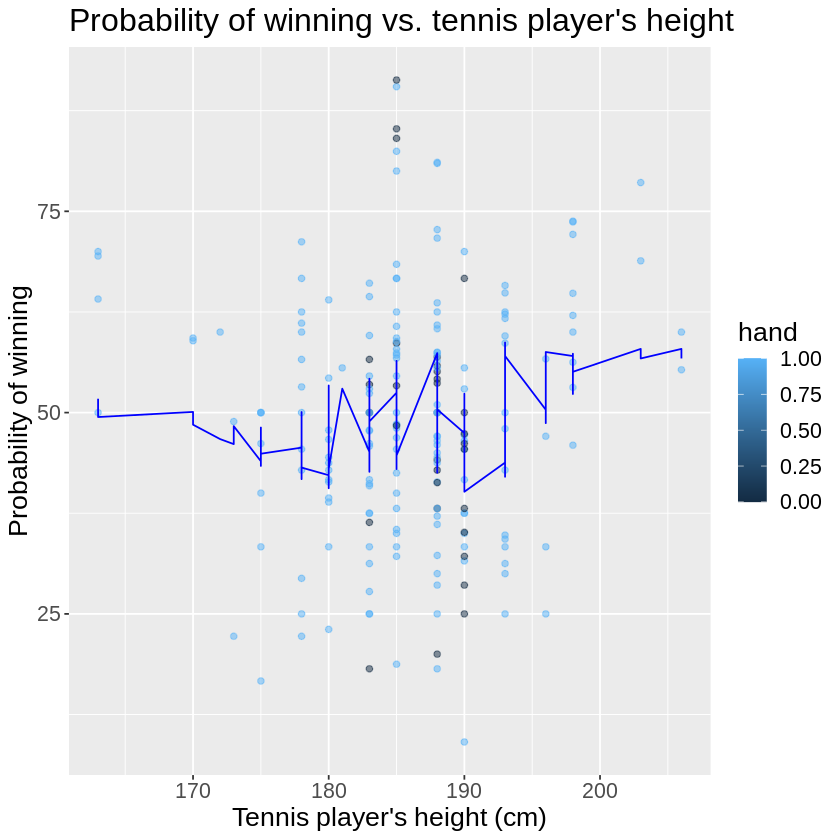

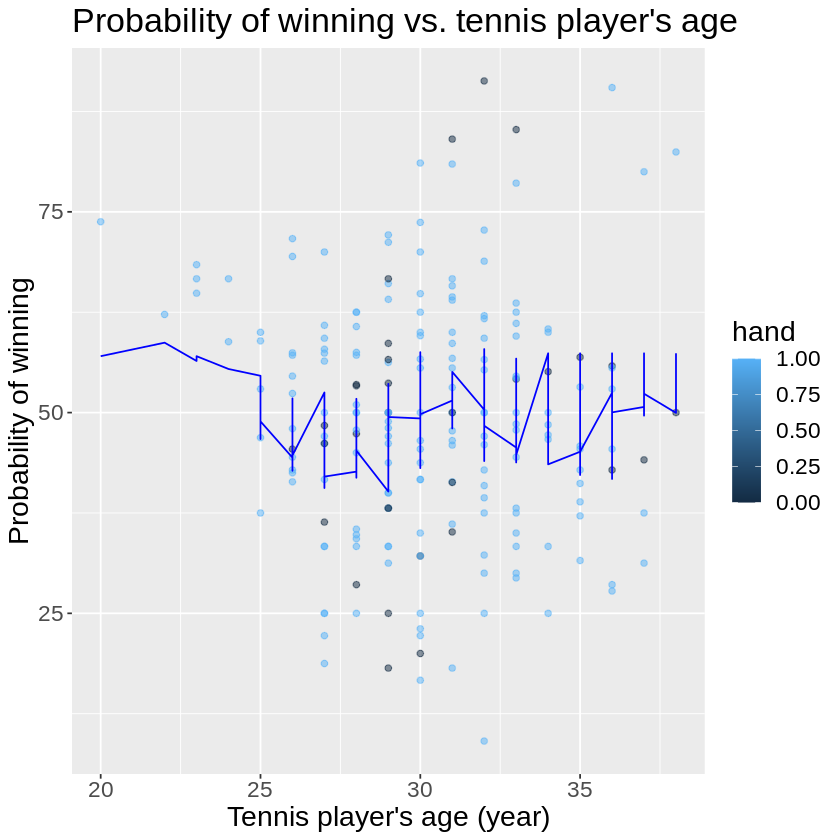

In [83]:
set.seed(2019)

options(repr.plot.width = 7, repr.plot.height = 7)

tennis_preds <- predict(tennis_best_fit, tennis_train) %>%
          bind_cols(tennis_train)

tennis_plot_height <- ggplot(tennis_preds, aes(x = height, y = prob_winning, colour = hand)) +
            geom_point(alpha = 0.5) +
            geom_line(data = tennis_preds,
            mapping = aes(x = height, y = .pred), color = "blue") +
            xlab("Tennis player's height (cm)") +
            ylab("Probability of winning") + 
            ggtitle("Probability of winning vs. tennis player's height") + 
            theme(text = element_text(size = 16))

tennis_plot_age <- ggplot(tennis_preds, aes(x = age, y = prob_winning, colour = hand)) +
            geom_point(alpha = 0.5) +
            geom_line(data = tennis_preds,
            mapping = aes(x = age, y = .pred), color = "blue") +
            xlab("Tennis player's age (year)") +
            ylab("Probability of winning") + 
            ggtitle("Probability of winning vs. tennis player's age") + 
            theme(text = element_text(size = 17))

tennis_plot_height
tennis_plot_age

#### 2.5.2 Linear Regression

In [57]:
tennis_reg_recipe <- recipe(prob_winning ~ height + age + hand, data = tennis_train)

tennis_reg_spec <- linear_reg() %>% 
    set_engine("lm") %>% 
    set_mode("regression")

tennis_reg_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

In [58]:
tennis_reg_fit <- workflow() %>% 
    add_recipe(tennis_reg_recipe) %>% 
    add_model(tennis_reg_spec) %>% 
    fit(data = tennis_train)

tennis_reg_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)       height          age         hand  
    32.2707       0.1294      -0.2517       0.5071  


In [59]:
tennis_reg_results <- tennis_reg_fit %>% 
    predict(tennis_test) %>% 
    bind_cols(tennis_test) %>% 
    metrics(truth = prob_winning, estimate = .pred)
tennis_reg_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,14.9228141
rsq,standard,0.1174921
mae,standard,11.6691924


In [60]:
tennis_reg_coeffs <- tennis_reg_fit %>% 
    pull_workflow_fit() %>% 
    tidy()

tennis_reg_coeffs

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),32.2706910,29.5436795,1.0923044,0.2760133
height,0.1294312,0.1531441,0.8451595,0.3990317
age,-0.2516932,0.3243717,-0.7759407,0.4387006
hand,0.5070777,2.9370273,0.1726500,0.8631012


The mathematical equation for the plane is:
    
    prob_winning = 0.112 + 0.00025 * (height) + 0.016 * (age) + 0.119 * (hand)

## 3.0 Discussion


## 4.0 References

